## Imports

In [1]:
import random
import numpy
import matplotlib.pyplot as plt

## Gray code encoding

In [2]:
def digit_to_gray(x):
  if x == '0':
    return [0, 0, 0, 0]
  elif x == '1':
    return [0, 0, 0, 1]
  elif x == '2':
    return [0, 0, 1, 1]
  elif x == '3':
    return [0, 0, 1, 0]
  elif x == '4':
    return [0, 1, 1, 0]
  elif x == '5':
    return [0, 1, 1, 1]
  elif x == '6':
    return [0, 1, 0, 1]
  elif x == '7':
    return [0, 1, 0, 0]
  elif x == '8':
    return [1, 1, 0, 0]
  elif x == '9':
    return [1, 1, 0, 1]


def to_gray(x):
  result = []

  if x >= 0:
    result.append(0)
  else:
    result.append(1)

  x_str = str(abs(x))
  splitted = x_str.split('.')
  LHS = splitted[0]
  RHS = splitted[1]

  result.extend(digit_to_gray(LHS))
  result.extend(digit_to_gray(RHS))

  return result


def gray_to_digit(x):
  string = ''.join([str(bit) for bit in x])

  if string == '0000':
    return 0
  elif string == '0001':
    return 1
  elif string == '0011':
    return 2
  elif string == '0010':
    return 3
  elif string == '0110':
    return 4
  elif string == '0111':
    return 5
  elif string == '0101':
    return 6
  elif string == '0100':
    return 7
  elif string == '1100':
    return 8
  elif string == '1101':
    return 9
  return 0


def to_float(chromosome):
  sign = chromosome[0]
  LHS = chromosome[1:5]
  RHS = chromosome[5:9]

  string = ''

  if sign == 1:
    string += '-'

  string += str(gray_to_digit(LHS))
  string += '.'
  string += str(gray_to_digit(RHS))

  return round(float(string), 1)

## Genetic Algorithm Class

In [3]:
class GeneticEquationSolver:
  def __init__(self, generations, population_size,
               elitist_rate, mutation_rate):
    self.population = []
    self.population_size = population_size
    self.elitist_rate = elitist_rate
    self.generations = generations
    self.mutation_rate = mutation_rate
    self.func = None
    self.min_root = None
    self.max_root = None
    self.chromosome_length = None

  def set_function(self, func, min_root, max_root, chromosome_length):
    self.func = func
    self.min_root = min_root
    self.max_root = max_root
    self.chromosome_length = chromosome_length

  @staticmethod
  def create_chromosome():
    x = random.uniform(-9.0, 9.0)
    x = round(x, 1)
    return to_gray(x)

  def create_population(self):
    for _ in range(self.population_size):
      chromosome = self.create_chromosome()
      self.population.append(chromosome)

  def fitness(self, chromosome):
    x = to_float(chromosome)
    fx = self.func(x)
    return 1 / (1 + abs(fx))

  def ranked_population(self):
    return sorted(self.population,
                  key=lambda x: self.fitness(x),
                  reverse=True)

  def create_pool(self, ranked_pop):
    pool = []
    pop_size = len(ranked_pop)
    elitist_size = int (pop_size * self.elitist_rate)
    remain_size = pop_size - elitist_size

    for i in range(elitist_size):
      pool.append(ranked_pop[i])

    fits = [self.fitness(e) for e in ranked_pop]
    sum_fits = sum(fits)
    norm_fits = [e / sum_fits for e in fits]

    for i in range(remain_size):
      pick = random.random()
      for j in range(pop_size):
        if pick >= norm_fits[j]:
          pool.append(ranked_pop[j])
          break
      if pick < norm_fits[pop_size - 1]:
        pool.append(ranked_pop[pop_size - 1])

    return pool

  @staticmethod
  def crossover(parent1, parent2):
    size = len(parent1)
    child_part1 = []
    child_part2 = []
    cross_point = int(random.random() * size)
    for i in range(0, cross_point):
      child_part1.append(parent1[i])
    for i in range(cross_point, size):
      child_part2.append(parent2[i])
    child = child_part1 + child_part2
    return child

  def mutate(self, chromosome):
    size = len(chromosome)
    new = chromosome
    for i in range(size):
      if random.random() < self.mutation_rate:
        new[i] = 1 - chromosome[i]
    return new

  def crossover_pool(self, pool):
    new_pop = []
    pop_size = len(pool)
    elitist_size = int (pop_size * self.elitist_rate)
    remain_size = pop_size - elitist_size

    for i in range(elitist_size):
      new_pop.append(pool[i])

    for i in range(remain_size):
      parent1 = random.choice(pool)
      parent2 = random.choice(pool)
      child = self.crossover(parent1, parent2)
      new_pop.append(child)

    return new_pop

  def mutate_pool(self, pool):
    new_pop = []
    for i in range(len(pool)):
      mutated = self.mutate(pool[i])
      new_pop.append(mutated)
    return new_pop

  def set_population(self, new_pop):
    self.population = new_pop

  def next_generation(self):
    ranked_pop = self.ranked_population()
    pool = self.create_pool(ranked_pop)
    crossovered_pool = self.crossover_pool(pool)
    mutated_pool = self.mutate_pool(crossovered_pool)
    self.set_population(mutated_pool)

    # returned before new generation
    best_chromosome = ranked_pop[0]
    avg_fitness = sum([self.fitness(e) for e in ranked_pop]) / len(ranked_pop)
    return best_chromosome, avg_fitness

  def run(self):
    self.create_population()
    best_chromosomes = []
    avg_fitness = []
    for i in range(self.generations):
      best, avg = self.next_generation()
      best_chromosomes.append(best)
      avg_fitness.append(avg)
      self.print_log(i, avg, best, to_float(best), self.fitness(best))

    ranked_pop = self.ranked_population()
    best = ranked_pop[0]
    avg = sum([self.fitness(e) for e in ranked_pop]) / len(ranked_pop)
    best_chromosomes.append(best)
    avg_fitness.append(avg)
    self.print_log(self.generations, avg, best, to_float(best), self.fitness(best))

    return best_chromosomes, avg_fitness

  @staticmethod
  def print_log(i, avg, best, best_root, best_fit):
    print('Generation:', i)
    print('Average Fitness:', avg)
    print('Best Chromosomes:', best)
    print('Best Root:', best_root)
    print('Fitness:', best_fit)
    print('----------------')

## Hyperparams

In [4]:
POPULATION_SIZE = 100
ELITIST_RATE = 0.2
GENERATIONS = 10
MUTATION_RATE = 0.1

## Init GA Equation Solver

In [5]:
model = GeneticEquationSolver(GENERATIONS, POPULATION_SIZE, ELITIST_RATE, MUTATION_RATE)

func = lambda x: 9 * x ** 5 - 194.7 * x ** 4 + 1680.1 * x ** 3 - 7227.94 * x ** 2 + 15501.2 * x - 13257.2
model.set_function(func, -9, 9, 9)

## Train

In [6]:
bests, avg_fitness = model.run()
bests_fitness = numpy.array([model.fitness(e) for e in bests])

Generation: 0
Average Fitness: 0.05409662254292298
Best Chromosomes: [0, 1, 1, 1, 0, 1, 1, 0, 1]
Best Root: 0.9
Fitness: 0.0002463426273775402
----------------
Generation: 1
Average Fitness: 0.4094524714471258
Best Chromosomes: [0, 0, 1, 0, 0, 1, 1, 1, 1]
Best Root: 7.0
Fitness: 0.0008727983661214685
----------------
Generation: 2
Average Fitness: 0.4426251814892512
Best Chromosomes: [0, 0, 1, 1, 0, 1, 1, 0, 1]
Best Root: 4.9
Fitness: 0.9780525018472449
----------------
Generation: 3
Average Fitness: 0.4633273728929855
Best Chromosomes: [0, 0, 1, 1, 0, 1, 1, 1, 1]
Best Root: 4.0
Fitness: 0.8064516129069168
----------------
Generation: 4
Average Fitness: 0.44826113800852385
Best Chromosomes: [0, 0, 1, 1, 0, 1, 1, 0, 1]
Best Root: 4.9
Fitness: 0.9780525018472449
----------------
Generation: 5
Average Fitness: 0.4601089294715804
Best Chromosomes: [0, 0, 1, 0, 0, 1, 1, 0, 1]
Best Root: 7.9
Fitness: 0.00019843760784463724
----------------
Generation: 6
Average Fitness: 0.4835999318742338
Be

## Results

Text(0.5, 23.52222222222222, 'Generation')

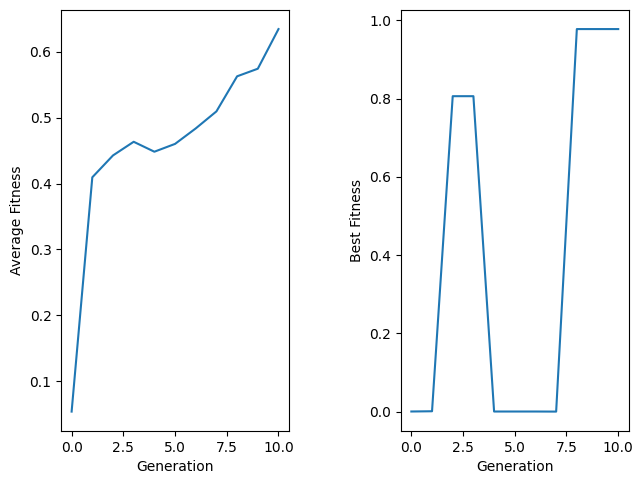

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(w_pad=5)

ax1.plot(avg_fitness)
ax1.set_ylabel('Average Fitness')
ax1.set_xlabel('Generation')

ax2.plot(bests_fitness)
ax2.set_ylabel('Best Fitness')
ax2.set_xlabel('Generation')